In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils as u
from scipy.integrate import simps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Function to compute power in given regions
def compute_power(kde, regions):
    signal_power = 0
    for region in regions:
        start, end = region
        signal_power += np.sum(kde[start:end+1] ** 2)
    return signal_power

In [11]:
# Load track info
tracks = [
    {"raga": "thodi", "piece": "Karuna Nidhi Illalo"},
    {"raga": "thodi", "piece": "Koluvamaregatha"},
    {"raga": "thodi", "piece": "Munnu Ravana"},
    {"raga": "thodi", "piece": "Thappi Bratikipova"},
    {"raga": "kalyani", "piece": "Kailasapathe"},
    {"raga": "kalyani", "piece": "Sundari Nee Divya"},
    {"raga": "kalyani", "piece": "Vandalum"}
]

# Dictionary to store KDE values
kde_values = {}

for track in tracks:
    raga = track["raga"]
    piece = track["piece"]
    if piece == "Munnu Ravana" or piece == "Vandalum":
        vimfile = f"{raga}/{piece}/{piece}.multitrack-violin-KDE.txt"
        vomfile = f"{raga}/{piece}/{piece}.multitrack-vocal-KDE.txt"

        vim = np.loadtxt(vimfile)[:, 1]
        vom = np.loadtxt(vomfile)[:, 1]
    else:
        # Load data
        via_file = raga + "/" + piece + "/" + piece + ".multitrack-violin-alaapana-KDE.txt"
        vim_file = raga + "/" + piece + "/" + piece + ".multitrack-violin-main-KDE.txt"
        voa_file = raga + "/" + piece + "/" + piece + ".multitrack-vocal-alaapana-KDE.txt"
        vom_file = raga + "/" + piece + "/" + piece + ".multitrack-vocal-main-KDE.txt"

        # Load the second column only (kde values)
        via = np.loadtxt(via_file)[:, 1]
        vim = np.loadtxt(vim_file)[:, 1]
        voa = np.loadtxt(voa_file)[:, 1]
        vom = np.loadtxt(vom_file)[:, 1]

    kde_values[piece] = {
        "via": via,
        "vim": vim,
        "voa": voa,
        "vom": vom
    }


x = np.linspace(0, 1200, 1200)
psnr_dict = {}

Violin peak regions: [(0, 34), (59, 119), (469, 529), (861, 921), (1163, 1200)]
Vocal peak regions: [(0, 41), (437, 497), (663, 723), (862, 922), (1153, 1200)]


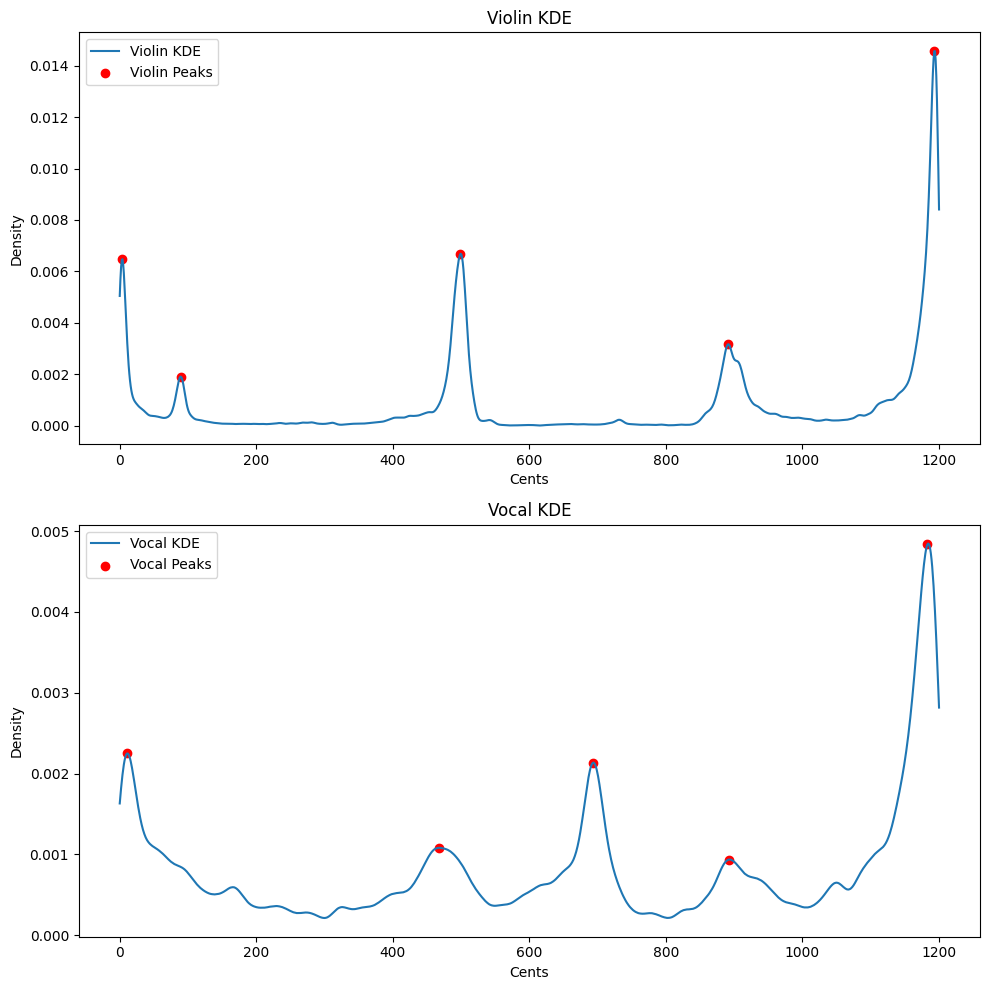

Violin PSNR: 14.36 dB
Vocal PSNR: 4.65 dB


/tmp/ipykernel_13600/2717390417.py:56: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  violin_signal_power = sum([simps(violin_kde[(x >= start) & (x <= end)] ** 2, x[(x >= start) & (x <= end)])
/tmp/ipykernel_13600/2717390417.py:58: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  violin_total_power = simps(violin_kde ** 2, x)
/tmp/ipykernel_13600/2717390417.py:65: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  vocal_signal_power = sum([simps(vocal_kde[(x >= start) & (x <= end)] ** 2, x[(x >= start) & (x <= end)])
/tmp/ipykernel_13600/2717390417.py:67: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  vocal_total_power = simps(vocal_kde ** 2, x)


In [43]:
# First track
piece = "Munnu Ravana"
violin_kde = kde_values[piece]["vim"]
vocal_kde = kde_values[piece]["vom"]

vi_peaks,_ = u.find_peaks(violin_kde, distance = 50, height = 0.0008)
vo_peaks,_ = u.find_peaks(vocal_kde, distance = 50, height = 0.0008)

# For each peak, select the region +30 and -30 around
violin_peak_regions = []
vocal_peak_regions = []
for peak in vi_peaks:
    start_peak = peak - 30
    end_peak = peak + 30
    # If start_peak is negative, set it to 0, if end_peak is greater than 1200, set it to 1200
    if start_peak < 0:
        start_peak = 0
    if end_peak > 1200:
        end_peak = 1200
    violin_peak_regions.append((start_peak, end_peak))

for peak in vo_peaks:
    start_peak = peak - 30
    end_peak = peak + 30
    # If start_peak is negative, set it to 0, if end_peak is greater than 1200, set it to 1200
    if start_peak < 0:
        start_peak = 0
    if end_peak > 1200:
        end_peak = 1200
    vocal_peak_regions.append((start_peak, end_peak))

print("Violin peak regions:", violin_peak_regions)
print("Vocal peak regions:", vocal_peak_regions)

# Plot KDEs as a 2 x 1 subplot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(x, violin_kde, label="Violin KDE")
axs[0].scatter(vi_peaks, violin_kde[vi_peaks], color='red', label="Violin Peaks")
axs[0].set_title("Violin KDE")
axs[0].set_xlabel("Cents")
axs[0].set_ylabel("Density")

axs[0].legend()

axs[1].plot(x, vocal_kde, label="Vocal KDE")
axs[1].scatter(vo_peaks, vocal_kde[vo_peaks], color='red', label="Vocal Peaks")
axs[1].set_title("Vocal KDE")
axs[1].set_xlabel("Cents")
axs[1].set_ylabel("Density")
axs[1].legend()

plt.tight_layout()
plt.show()

# Calculate signal and noise power for violin
violin_signal_power = sum([simps(violin_kde[(x >= start) & (x <= end)] ** 2, x[(x >= start) & (x <= end)])
                           for start, end in violin_peak_regions])
violin_total_power = simps(violin_kde ** 2, x)
violin_noise_power = violin_total_power - violin_signal_power

# Calculate PSNR for violin
violin_psnr = 10 * np.log10(violin_signal_power / violin_noise_power)

# Repeat for vocal
vocal_signal_power = sum([simps(vocal_kde[(x >= start) & (x <= end)] ** 2, x[(x >= start) & (x <= end)])
                          for start, end in vocal_peak_regions])
vocal_total_power = simps(vocal_kde ** 2, x)
vocal_noise_power = vocal_total_power - vocal_signal_power

# Calculate PSNR for vocal
vocal_psnr = 10 * np.log10(vocal_signal_power / vocal_noise_power)

print(f"Violin PSNR: {violin_psnr:.2f} dB")
print(f"Vocal PSNR: {vocal_psnr:.2f} dB")

# Save to dict
psnr_dict[piece].update({
    "vim": violin_psnr,
    "vom": vocal_psnr
})


In [46]:
print(psnr_dict)

{'Karuna Nidhi Illalo': {'via': 8.761875563402523, 'voa': 5.85121935336392, 'vim': 12.906732936656082, 'vom': 6.045759973524745}, 'Koluvamaregatha': {'via': 15.946344644784816, 'voa': 6.798993645293663, 'vim': 13.956757311592888, 'vom': 5.394146585047384}, 'Munnu Ravana': {'vim': 14.358485177108184, 'vom': 4.6529200850370644, 'via': None, 'voa': None}, 'Thappi Bratikipova': {'via': 19.932934358624184, 'voa': 6.1702283735616135, 'vim': 17.284458735194427, 'vom': 6.36843029386879}, 'Kailasapathe': {'vim': 15.791443598130224, 'vom': 4.943458508235031, 'via': 16.583398560564845, 'voa': 4.278002356661032}, 'Sundari Nee Divya': {'via': 13.423570880734133, 'voa': 4.416956958263038, 'vim': 15.374031722639101, 'vom': 3.778606613001856}, 'Vandalum': {'vim': 14.836875550436945, 'vom': 6.622120819659552, 'via': None, 'voa': None}}


In [84]:
# Convert psnr_dict to a dataframe
psnr_df = pd.DataFrame(psnr_dict).T
psnr_df = psnr_df.reset_index()
psnr_df.columns = ["Piece", "Violin Alaapana PSNR", "Vocal Alaapana PSNR", "Violin Main PSNR", "Vocal Main PSNR"]

# Save to CSV
psnr_df.to_csv("psnr.csv", index=False)
psnr_df

,Piece,Violin Alaapana PSNR,Vocal Alaapana PSNR,Violin Main PSNR,Vocal Main PSNR
0,Karuna Nidhi Illalo,8.761876,5.851219,12.906733,6.045760
1,Koluvamaregatha,15.946345,6.798994,13.956757,5.394147
2,Munnu Ravana,NaN,NaN,14.358485,4.652920
3,Thappi Bratikipova,19.932934,6.170228,17.284459,6.368430
4,Kailasapathe,16.583399,4.278002,15.791444,4.943459
5,Sundari Nee Divya,13.423571,4.416957,15.374032,3.778607
6,Vandalum,NaN,NaN,14.836876,6.622121


In [85]:
# Move violin main column to the left
cols = psnr_df.columns.tolist()
cols = cols[:2] + cols[3:] + [cols[2]]
psnr_df = psnr_df[cols]
psnr_df


,Piece,Violin Alaapana PSNR,Violin Main PSNR,Vocal Main PSNR,Vocal Alaapana PSNR
0,Karuna Nidhi Illalo,8.761876,12.906733,6.045760,5.851219
1,Koluvamaregatha,15.946345,13.956757,5.394147,6.798994
2,Munnu Ravana,NaN,14.358485,4.652920,NaN
3,Thappi Bratikipova,19.932934,17.284459,6.368430,6.170228
4,Kailasapathe,16.583399,15.791444,4.943459,4.278002
5,Sundari Nee Divya,13.423571,15.374032,3.778607,4.416957
6,Vandalum,NaN,14.836876,6.622121,NaN


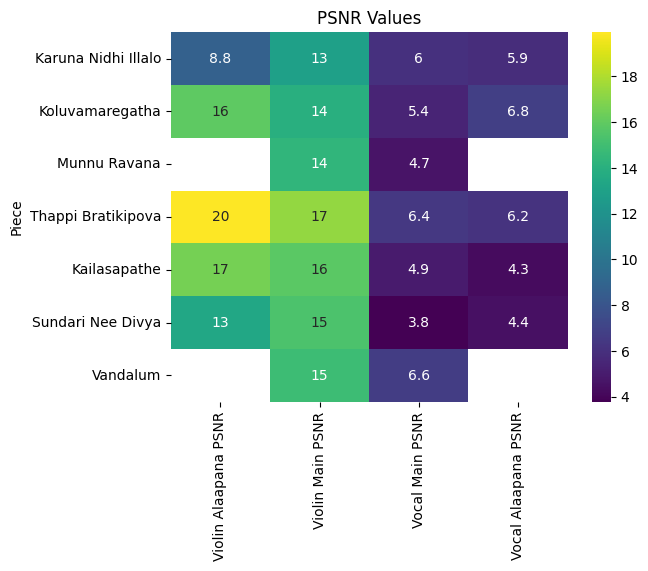

In [87]:
# Create a heatmap
sns.heatmap(psnr_df.set_index("Piece"), annot=True, cmap="viridis")
plt.title("PSNR Values")
plt.show()

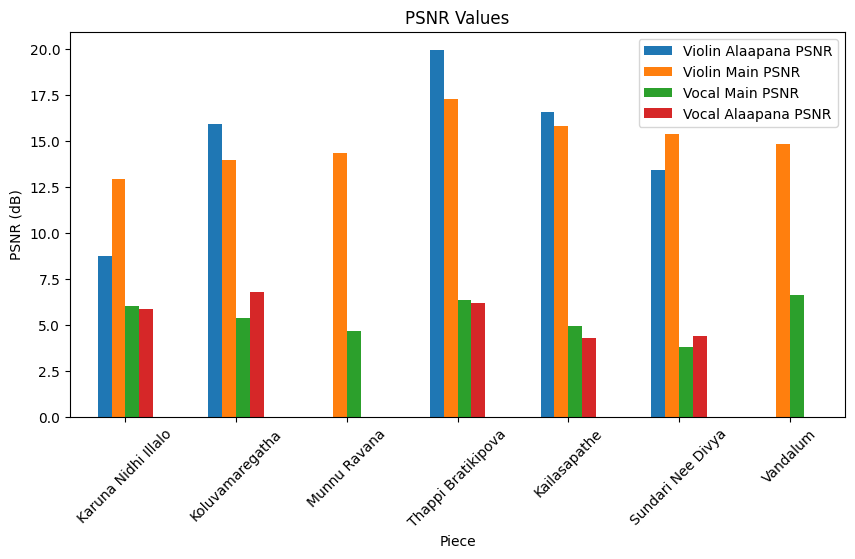

In [88]:
# Create a cluster bar plot 
psnr_df = psnr_df.set_index("Piece")
psnr_df.plot(kind="bar", figsize=(10, 5))
plt.title("PSNR Values")
plt.xticks(rotation=45)
plt.ylabel("PSNR (dB)")
plt.show()